# Importing the required libraries 

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import cloudpickle
import pickle

# Importing the data and forming raw features and target dataframes

In [8]:
df = pd.read_csv("data.csv")
X = df.drop(columns=['Loan_ID'])
y = X['Loan_Status']
y = y.replace({'Y': 1, 'N':0}).values
X = X.drop(columns='Loan_Status')

# Splitting dataframes for training and testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=123)

# Building standardization piplines

In [71]:
numeric_standardization = Pipeline([('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler())])
categorical_standardization = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')),
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

# Defining transformations (filters) for filtering numeric and categorical features

In [72]:
def numFeat(data):
    cat_feats = catFeat(data)
    num_feats = data.dtypes[~data.dtypes.index.isin(cat_feats)].index.tolist()
    return data[num_feats]

def catFeat(data):
    cat_feats = data.dtypes[data.dtypes == 'object'].index.tolist()
    return data[cat_feats]

# we will start two separate pipelines for each type of features
keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# Defining transformations to deal with outliers in numeric features

In [73]:
def total_log_transform(X):
    X = X.assign(Total_Income_Log= np.log10(X[['ApplicantIncome', 'CoapplicantIncome']].sum(axis=1)))
    X = X.assign(LoanAmount_Log = np.log10(X[['LoanAmount']]))
    X = X.drop(columns=['ApplicantIncome', 'CoapplicantIncome','LoanAmount'])
    return X

total_log_transform_object = FunctionTransformer(total_log_transform)

#total_log_transform(X_train)

# Building pipelines for numeric features

In [75]:
numeric_transform = Pipeline([('total_log',total_log_transform_object),
                              ('select_numeric', keep_num),
                              ('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler()),
                              ('pca', PCA())])

In [76]:
#numeric_transform.fit(X_train)

# Building pipelines for categorical features

In [77]:
categorical_transform = Pipeline([('select_categorical', keep_cat),
                                  ('impute_mode', SimpleImputer(strategy='most_frequent')),
                                  ('one-hot-encode', OneHotEncoder(sparse=False)),
                                  ('select_best', SelectKBest())])

In [78]:
#categorical_transform.fit(X_train)

# Unifying the features

In [79]:
feature_union = FeatureUnion([('numeric_transform', numeric_transform),
                              ('categorical_transform', categorical_transform)])

# Building the modeling pipeline

In [80]:
baseline_model_pipeline = Pipeline(steps=[('features', feature_union),
                                 ('classifier', DecisionTreeClassifier())])

In [81]:
#baseline_model_pipeline.fit(X_train, y_train)

# Grid search for baseline model, looking for best model and features selection parameters

In [61]:
params = {'features__numeric_transform__pca__n_components':[2,3,4],
          'features__categorical_transform__select_best__k':[1,2,3,4,5,6,7],
          'classifier': [DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(), GradientBoostingClassifier()] }

grid = GridSearchCV(baseline_model_pipeline, param_grid=params, cv=5)
grid.fit(X_train,y_train)


best_hyperprameters = grid.best_params_
best_acc = grid.score(X_test,y_test)

print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperprameters}')

Best test set accuracy: 0.7886178861788617
Achieved with hyperparameters: {'classifier': RandomForestClassifier(), 'features__categorical_transform__select_best__k': 5, 'features__numeric_transform__pca__n_components': 4}


# Grid search for selected model, looking for best model parameters

In [82]:
model_pipeline = Pipeline(steps=[('features', feature_union),
                                 ('classifier', RandomForestClassifier())])

params = {'features__numeric_transform__pca__n_components':[4],
          'features__categorical_transform__select_best__k':[5],
          'classifier__max_depth': [2,3,4,5,6,7],
          'classifier__n_estimators': [10,20,30,40,50,60,70]}

grid = GridSearchCV(model_pipeline, param_grid=params, cv=10)
grid.fit(X_train,y_train)


best_hyperprameters = grid.best_params_
best_acc = grid.score(X_test,y_test)

print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperprameters}')

Best test set accuracy: 0.7886178861788617
Achieved with hyperparameters: {'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'features__categorical_transform__select_best__k': 5, 'features__numeric_transform__pca__n_components': 4}


# Tesing the final model

In [83]:
numeric_transform = Pipeline([('total_log',total_log_transform_object),
                              ('select_numeric', keep_num),
                              ('impute_mean', SimpleImputer(strategy='mean')),
                              ('scaling', StandardScaler()),
                              ('pca', PCA(n_components=5))])

categorical_transform = Pipeline([('select_categorical', keep_cat),
                                  ('impute_mode', SimpleImputer(strategy='most_frequent')),
                                  ('one-hot-encode', OneHotEncoder(sparse=False)),
                                  ('select_best', SelectKBest(k=6))])

final_model_pipeline = Pipeline(steps=[('features', feature_union),
                                 ('classifier', RandomForestClassifier(max_depth=3,n_estimators=40))])

final_model_pipeline.fit(X_train, y_train)

y_pred = final_model_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {acc}')

Test set accuracy: 0.7804878048780488


# Save the model as pickle

In [497]:
#pickle.dump(final_model_pipeline, open('model.pkl', 'wb'))

with open('model.clpkl', 'wb') as f:
    cloudpickle.dump(final_model_pipeline,f)

# Testing the pickle model

In [10]:
#model = pickle.load(open('model.pkl', 'rb'))
#model = pickle.load(open('model.clpkl', 'rb'))

with open('model.clpkl', 'rb') as f:
    model = cloudpickle.load(f)

result = model.score(X_test,y_test)
print(result)

0.7804878048780488


In [10]:
df0 = X_test.iloc[:1,:]
test = df0.to_json(orient='records')
#df = pd.DataFrame(test.values(), index =test.keys())
#df = X_test.iloc[:5,:]

In [11]:
test

'[{"Gender":"Male","Married":"Yes","Dependents":"1","Education":"Graduate","Self_Employed":"No","ApplicantIncome":1880,"CoapplicantIncome":0.0,"LoanAmount":61.0,"Loan_Amount_Term":360.0,"Credit_History":null,"Property_Area":"Rural"}]'

In [12]:
test = {"Gender":"Male","Married":"Yes","Dependents":"1","Education":"Graduate","Self_Employed":"No","ApplicantIncome":1880.0,"CoapplicantIncome":0.0,"LoanAmount":61.0,"Loan_Amount_Term":360.0,"Credit_History":1.0,"Property_Area":"Rural"}

In [13]:
type(test['Loan_Amount_Term'])

float

In [14]:
df = pd.DataFrame(test.values(), index =test.keys()).transpose()

In [15]:
df0

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
583,Male,Yes,1,Graduate,No,1880,0.0,61.0,360.0,NaN,Rural


In [16]:
type(df0.iloc[0]['Loan_Amount_Term'])

numpy.float64

In [17]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,1,Graduate,No,1880,0,61,360,1,Rural


In [18]:
df = df.astype({'ApplicantIncome': np.float64, 'CoapplicantIncome': np.float64, 'LoanAmount': np.float64, 'Loan_Amount_Term': np.float64, 'Credit_History': np.float64})
type(df.iloc[0]['Loan_Amount_Term'])

numpy.float64

In [26]:
result = model.predict(df)
print(result)

[1]


# Testing the deployed mode

In [19]:
import requests as r
import pandas as pd
import json

In [22]:
base_url = 'http://ec2-**-***-***-**.compute-1.amazonaws.com:8888/'

In [25]:
response = r.post(base_url + "predict", json = test)
if response.status_code == 200:
    print('...')
    print('request successful')
    print('...')
    print(response.json())
else:
    print('request failed')

...
request successful
...
[1]


# Model Precision

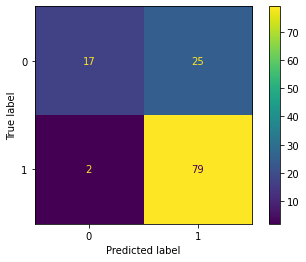

In [84]:
plot_confusion_matrix(model, X_test, y_test)

In [85]:
result = model.score(X_train,y_train)
print(result)

0.8085539714867617
